## Imports

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Data

In [33]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_data[0][0].shape

torch.Size([1, 28, 28])

In [34]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

## Model

In [35]:
class VAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc_mu = nn.Linear(1024, 20)
        self.fc_sigma = nn.Linear(1024, 20)

        self.fc2 = nn.Linear(20, 1024)
        self.fc3 = nn.Linear(1024, 256*4*4)

        self.transpose1 = nn.ConvTranspose2d(256, 128, 3, 2, 1)
        self.transpose2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.transpose3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.transpose4 = nn.ConvTranspose2d(32, 1, 3, 1, 1)

        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(64)
        self.bn7 = nn.BatchNorm2d(32)

    
    def encoder(self, input):
        x = torch.relu(self.bn1(self.conv1(input)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        

        x = x.view(-1, 256*4*4)

        x = self.fc1(x)
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)

        return mu, sigma
    

    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)

        return mu + eps * (torch.exp(0.5 * sigma))
    
    def decoder(self, z):

        z = torch.relu(self.fc2(z))
        z = torch.relu(self.fc3(z))

        z = z.view(-1, 256, 4, 4)

        z = torch.relu(self.bn5(self.transpose1(z)))
        z = torch.relu(self.bn6(self.transpose2(z)))
        z = torch.relu(self.bn7(self.transpose3(z)))

        z = torch.sigmoid(self.transpose4(z))

        return z
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        decoded = self.decoder(z)

        return mu, sigma, decoded


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:
model = VAE().to(device)
model

VAE(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc_mu): Linear(in_features=1024, out_features=20, bias=True)
  (fc_sigma): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=4096, bias=True)
  (tra

## Train

In [38]:
def vae_loss(recon_x, x, mu, sigma):
    criterion = nn.BCELoss(reduction='sum')
    recon_loss = criterion(recon_x, x)

    kl_loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

    loss = recon_loss + kl_loss

    return loss

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 40

In [40]:
for epoch in range(EPOCHS):

    epoch_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        mu, sigma, x_reconst = model(x)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            loss = vae_loss(x_reconst, x, mu, sigma)
            loss.backward()
            optimizer.step()

        epoch_loss += loss

    print(f'epoch{epoch} loss: {epoch_loss}')

epoch0 loss: 7281934.5
epoch1 loss: 6360243.5
epoch2 loss: 6179770.0
epoch3 loss: 6070091.5
epoch4 loss: 5993757.0
epoch5 loss: 5935467.0
epoch6 loss: 5890907.5
epoch7 loss: 5855821.0
epoch8 loss: 5823432.5
epoch9 loss: 5800655.5
epoch10 loss: 5776009.0
epoch11 loss: 5757637.5
epoch12 loss: 5740587.5
epoch13 loss: 5723518.0
epoch14 loss: 5709404.0
epoch15 loss: 5695927.0
epoch16 loss: 5681567.5
epoch17 loss: 5672450.5
epoch18 loss: 5659185.0
epoch19 loss: 5651089.5
epoch20 loss: 5642653.0
epoch21 loss: 5631959.0
epoch22 loss: 5623672.5
epoch23 loss: 5615472.5
epoch24 loss: 5605484.0
epoch25 loss: 5602502.5
epoch26 loss: 5595939.5
epoch27 loss: 5587775.5
epoch28 loss: 5579268.5
epoch29 loss: 5575853.5
epoch30 loss: 5567870.5
epoch31 loss: 5566894.5
epoch32 loss: 5558709.5
epoch33 loss: 5550905.5
epoch34 loss: 5548839.0
epoch35 loss: 5544269.0
epoch36 loss: 5537854.0
epoch37 loss: 5533803.5
epoch38 loss: 5530531.5
epoch39 loss: 5521702.5


## Test

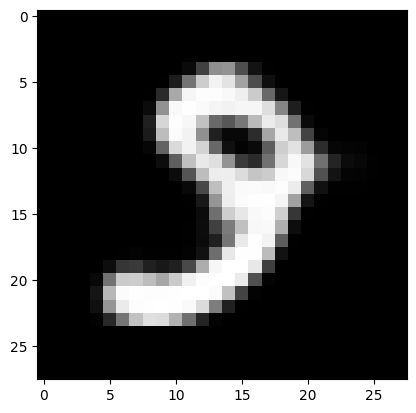

In [46]:
mu = torch.zeros(20)
sigma = torch.ones(20)
n_samples = 1
latent_vars = torch.normal(mu, sigma.expand(n_samples, -1)).to(device)

with torch.no_grad():
    decoded_data = model.decoder(latent_vars)

decoded_data_np = decoded_data.cpu().numpy().reshape(28, 28)
plt.imshow(decoded_data_np, cmap='gray')
plt.show()


In [44]:
FILE = "model.pth"
torch.save(model, FILE)